## Using Size loss with Cardiac Images

For this phase of the tutorial, we are going to apply the Size loss function to a real-world medical image segmentation problem. In particular, the Automatic Cardiac Diagnosis Challenge (ACDC) from MICCAI 2017. To download the dataset, please visit the website:
https://drive.google.com/u/0/uc?id=1iSnZRwQ1snbnVnQM-pwoWTa3UwPuJR3U&export=download. After having downloaded the zip file, we can simply drag it to the file section at the left of the screen. Make sure that the file is placed in the path <code> weakly_supervised_summerschool/code/data <code>.
    
To unzip the data, go back to the Terminal and open the directory where the zip file was placed. Once there, use the following command to unzip: <code> unzip ACDC-2D-All-Semi.zip <code>

At the end, you will se a folder named "ACDC-2D-ALL" available next to the toy dataset folder.

**Libraries**

In [1]:
import argparse
from pathlib import Path
from typing import Any, Tuple
from operator import itemgetter
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn, einsum
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

**Utilities**

In [2]:
from utils.dataset import (ACDC)
from utils.residual_unet import ResidualUNet
from utils.losses import (CrossEntropy,
                          PartialCrossEntropy,
                          NaiveSizeLoss)
from utils.utils import (weights_init,
                         saveImages,
                         class2one_hot,
                         probs2one_hot,
                         one_hot,
                         tqdm_,
                         dice_coef)

**Configuring GPU**

If there is an available GPU, it is going to be contained in the variable 'device', otherwise it is going to be simply the GPU.

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

# ACDC Dataset

In this more advanced example, we directly apply the concept of Size loss to the segmentation of cardiac MRI images. As before, our first task is to load the data in order to analize it.

In [4]:
root_dir = 'data/ACDC-2D-All/'

'''Specifying the transforms for the data during training'''
transform = transforms.Compose([
                lambda img: img.convert('L'),
                lambda img: np.array(img)[np.newaxis, ...],
                lambda nd: nd /255,
                lambda nd: torch.tensor(nd, dtype=torch.float32)])

mask_transform = transforms.Compose([
                    lambda img: np.array(img)[...],
                    lambda nd: nd / 255,
                    lambda nd: torch.tensor(nd, dtype=torch.int64)[None, ...],
                    lambda t: class2one_hot(t, K=4),
                    itemgetter(0)])
weak_transform = transforms.Compose([
                    lambda img: np.array(img)[...],
                    lambda nd: nd / 255,
                    lambda nd: torch.tensor(nd, dtype=torch.int64)[None, ...],
                    lambda t: class2one_hot(t, K=2),
                    itemgetter(0)])

In [5]:
batch_size = 1
'''Creating dataset objects to handle all our data samples'''
train_set = ACDC('train', root_dir, transform=transform, mask_transform=mask_transform, weak_transform=weak_transform, augment=True, equalize=False)
val_set = ACDC('val', root_dir, transform=transform, mask_transform=mask_transform, weak_transform=weak_transform, equalize=False)

'''Creating dataloaders, which help us iterate over the data samples'''
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, num_workers=4, shuffle=False)

>> Created train dataset with 102 images...
>> Created val dataset with 404 images...


In [6]:
train_set[0]

torch.Size([4, 256, 256])
torch.Size([2, 256, 256, 3])


AssertionError: 

In [7]:
from utils.dataset import make_dataset
from PIL import Image, ImageOps
files = make_dataset(root_dir, 'train')
img_path, gt_path, weak_path = files[0]
img = Image.open(img_path)
mask = Image.open(gt_path)
weak_mask = Image.open(weak_path)#.convert('L')
print(mask.getbands())
mask = np.array(mask)[...]
print(mask.shape)
mask = mask/255
print(mask.shape)
mask = torch.tensor(mask, dtype=torch.int64)[None, ...]
print(mask.shape)
mask = class2one_hot(mask, K=4)
print(mask.shape)
'''img = transform(img)
mask = mask_transform(mask)
weak_mask = mask_transform(weak_mask)
print(weak_mask.shape)'''

('L',)
(256, 256)
(256, 256)
torch.Size([1, 256, 256])
torch.Size([1, 4, 256, 256])


'img = transform(img)\nmask = mask_transform(mask)\nweak_mask = mask_transform(weak_mask)\nprint(weak_mask.shape)'

In [28]:
from utils.dataset import make_dataset
from PIL import Image, ImageOps
files = make_dataset(root_dir, 'train')
img_path, gt_path, weak_path = files[0]
img = Image.open(img_path)
mask = Image.open(gt_path)
weak_mask = Image.open(weak_path)#.convert('L')
print(mask.getbands())
weak_mask = np.array(weak_mask)[...]
print(weak_mask.shape)
weak_mask = weak_mask/255
print(weak_mask.shape)
weak_mask = torch.tensor(weak_mask, dtype=torch.int64)[None, ...]
print(weak_mask.shape)
weak_mask = class2one_hot(weak_mask, K=2)
print(weak_mask.shape)
'''img = transform(img)
mask = mask_transform(mask)
weak_mask = mask_transform(weak_mask)
print(weak_mask.shape)'''

('L',)
(256, 256, 3)
(256, 256, 3)
torch.Size([1, 256, 256, 3])
torch.Size([1, 2, 256, 256, 3])


'img = transform(img)\nmask = mask_transform(mask)\nweak_mask = mask_transform(weak_mask)\nprint(weak_mask.shape)'

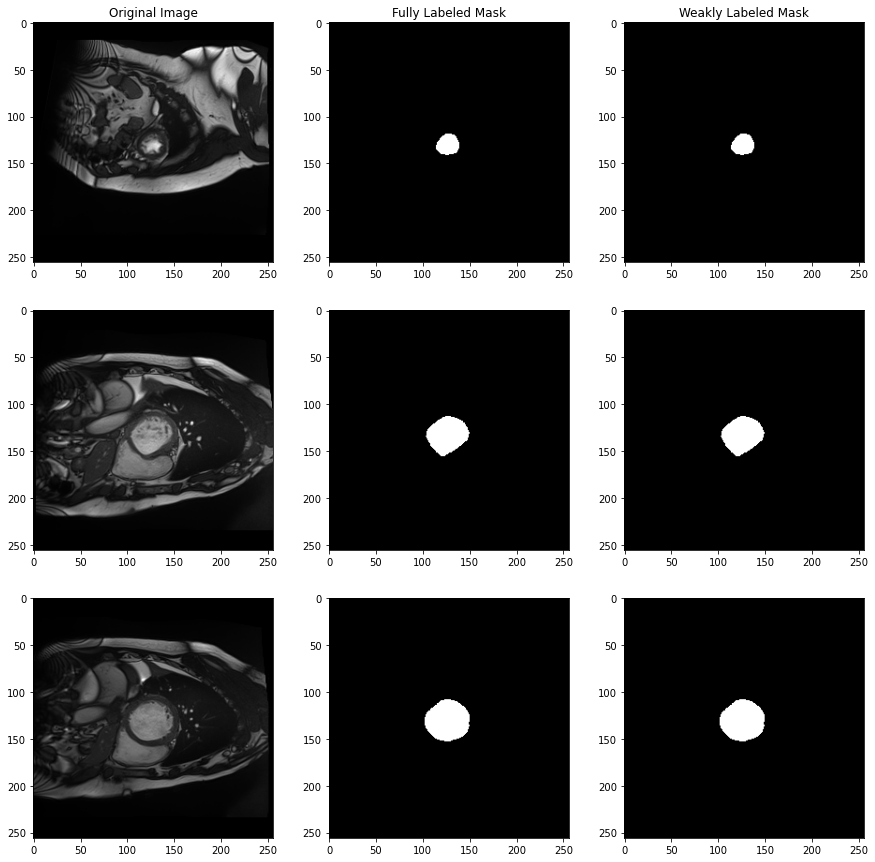

In [40]:
'''Displaying some examples'''
fig, axs = plt.subplots(3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(3):
    data = val_set[i+1]
    img = data['img'] #Image
    full_mask = data['full_mask'] #Fully annotated segmentation mask
    weak_mask = data['weak_mask'] #Weakly annotated segmentation mask
    axs[i,0].imshow(img.squeeze(), cmap='gray')
    axs[i,1].imshow(full_mask[1], cmap='gray')
    axs[i,2].imshow(weak_mask[1], cmap='gray')
axs[0,0].set_title('Original Image')
axs[0,1].set_title('Fully Labeled Mask')
axs[0,2].set_title('Weakly Labeled Mask')
plt.show()